In [2]:
import sys
sys.path.append('..')
import os
import shutil
import numpy as np
from tqdm.notebook import tqdm
from tqdm.contrib.concurrent import process_map
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import random
import seaborn as sns
import pandas as pd
import pickle

from multiprocess import Pool
from program.helper import *
from program.mlp_optimization import *
from program.utility import *

import torch
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import KFold

In [5]:
with open('../program/label_translator.pkl', 'rb') as pkl_file:
    label_translator = pickle.load(pkl_file)
label_translator

{0: 'abstract',
 1: 'aerial',
 2: 'animals',
 3: 'black and white',
 4: 'celebrities',
 5: 'city and architecture',
 6: 'commercial',
 7: 'concert',
 8: 'family',
 9: 'fashion',
 10: 'film',
 11: 'fine art',
 12: 'food',
 13: 'journalism',
 14: 'landscapes',
 15: 'macro',
 16: 'nature',
 17: 'night',
 18: 'people',
 19: 'performing arts',
 20: 'sport',
 21: 'still life',
 22: 'street',
 23: 'transportation',
 24: 'travel',
 25: 'underwater',
 26: 'urban exploration',
 27: 'wedding'}

## Pre-Processing

In [6]:
# Define a Composal of image transformation used for image load
transform_images = Compose([Resize((227, 227)), 
                            ToTensor(),
                            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [9]:
train_data = ImageFolder("../data/train", transform=transform_images)
test_data = ImageFolder("../data/test", transform=transform_images)

In [10]:
dataloader_train = DataLoader(train_data, batch_size=150, shuffle=True, 
                              num_workers=24, pin_memory=True)
dataloader_test = DataLoader(test_data, batch_size=150, shuffle=True, 
                             num_workers=24, pin_memory=True)

In [11]:
# Plot functions
def plot_evaluation_networks(losses: dict, accuracy: dict, key_names: list, sma=50):
    fig = plt.subplots(figsize=(15, 4))

    sns.set_palette('Paired', 4)
    sns.set_style('whitegrid')
    plt.subplot(1,2,1)
    lossSMA = losses.rolling(sma).mean()
    for name in key_names:
        p = sns.lineplot(x=np.arange(1, lossSMA.shape[0]+1), y=lossSMA[name],
                     label=name)
    p.set_title(f'Cost-Function of Different Networks (SMA{sma})', loc='left')
    p.set_xlabel('Mini-Batch Iterations')
    p.set_ylabel('Cross-Entropy Loss')
    p.set_xlim(0)
    plt.legend(loc='lower left')

    plt.subplot(1,2,2)
    p = sns.barplot(x=accuracy['index'], y=accuracy['value'], hue=accuracy['variable'])
    p.set_title('Accuracy after Optimization', loc='left')
    p.set_ylabel('Accuracy')
    p.set_xlabel('')
    p.set_xticklabels(['Train', 'Test'])
    plt.legend(title='Model:')

    plt.show()

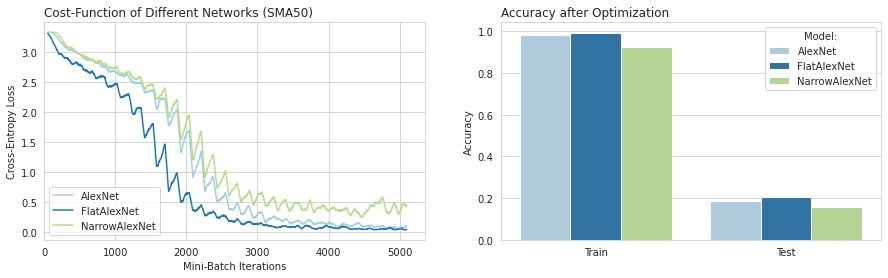

In [13]:
# load results
with open('../src/model_losses.pkl', 'rb') as pkl_file:
    model_losses = pickle.load(pkl_file)
with open('../src/model_acc.pkl', 'rb') as pkl_file:
    model_acc = pickle.load(pkl_file)
with open('../src/model_train_test_acc.pkl', 'rb') as pkl_file:
    model_train_test_metrics = pickle.load(pkl_file)

# Transform
model_losses = pd.DataFrame.from_dict(model_losses, orient='index').T
model_acc = pd.DataFrame.from_dict(model_acc)
tmp = pd.DataFrame.from_dict(model_train_test_metrics)

train_test_metrics = pd.DataFrame()
for col in tmp.columns:
    tmp_ = tmp.explode(column=col)[col]
    tmp_.index = ['Train Accuracy', 'Test Accuracy', 'Train Precision', 'Test Precision']
    train_test_metrics = pd.concat([train_test_metrics, tmp_], axis=1)
tmp = train_test_metrics.reset_index()

tmp = tmp[tmp['index'].str.contains('Accuracy')]
tmp = pd.melt(tmp, id_vars=['index'])

#Plot 
plot_evaluation_networks(losses=model_losses, 
                         accuracy=tmp, 
                         key_names=model_losses.columns.to_list(), sma=50)

In [14]:
def plot_loss(losses, sma=10, **args):
    sns.set_palette('Paired', 2)
    l = pd.Series(losses)
    plt.subplots(figsize=(12, 5))
    p = sns.lineplot(x=np.arange(len(l)), y=l)
    p = sns.lineplot(x=np.arange(len(l)), y=l.rolling(sma).mean(), label=f'SMA {sma}')

    plt.title(args.get('title'), fontsize=10)
    plt.suptitle('Loss over Epochs split into Batches')
    p.set_xlabel('Batches')
    p.set_ylabel('Loss')
    sns.despine()
    plt.show()

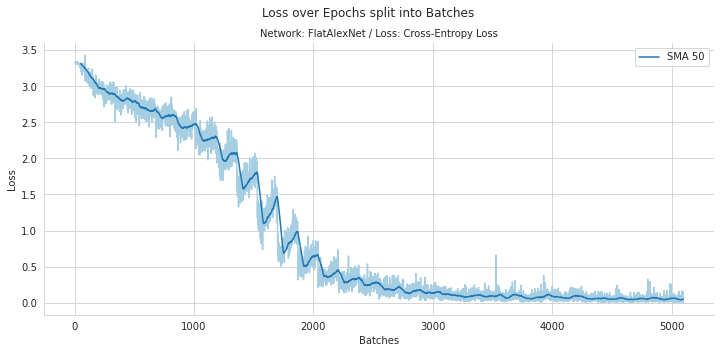

In [15]:
plot_loss(losses=model_losses['FlatAlexNet'], sma=50, title='Network: FlatAlexNet / Loss: Cross-Entropy Loss')

## S3: Kernel Sizes

#### Low Kernel Size Implementation

In [16]:
from networks import FlatAlexNetLowKernel, FlatAlexNetHighKernel

In [19]:
model_losses = {}
model_acc = {}
model_train_test_metrics = {}

In [20]:
model_losses['FlatAlexNetLowKernel'] = {}
model_acc['FlatAlexNetLowKernel'] = {}
model_train_test_metrics['FlatAlexNetLowKernel'] = {}

In [17]:
low_kernel_model = FlatAlexNetLowKernel(n_classes=28)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(low_kernel_model.parameters(), lr=.0035, momentum=.95)
dtype = torch.float32

In [18]:
print_total_params(low_kernel_model)

Trainable Parameters: 42691452


In [ ]:
low_kernel_model, losses = train_network(model=low_kernel_model, criterion=criterion, 
                                                    optimizer=optimizer, dataloader_train=dataloader_train, 
                                                    n_epochs=40)

In [25]:
model_losses['FlatAlexNetLowKernel'] = losses
model_acc['FlatAlexNetLowKernel'] = train_acc

In [26]:
metrics = calculate_metrics(dl_train=dataloader_train, dl_test=dataloader_test, model=low_kernel_model)
print('Train Accuracy / Test Accuracy: ', metrics['accuracy'],
      '\nTrain Precision / Test Precision: ', metrics['precision'])

Calculate Acc. on Test Data: 100%|██████████| 19/19 [00:03<00:00,  5.67it/s]

Train Accuracy / Test Accuracy:  [0.9894521410579346, 0.2446246034543532] 
Train Precision / Test Precision:  [0.9896731517820191, 0.2465052721271019]


In [27]:
model_train_test_metrics['FlatAlexNetLowKernel']['acc'] = metrics['accuracy']
model_train_test_metrics['FlatAlexNetLowKernel']['prec'] = metrics['precision']

In [28]:
y_true, y_pred = network_predict(model=low_kernel_model, dataloader=dataloader_test)

Calculate Acc. on Test Data: 100%|██████████| 19/19 [00:03<00:00,  5.69it/s]


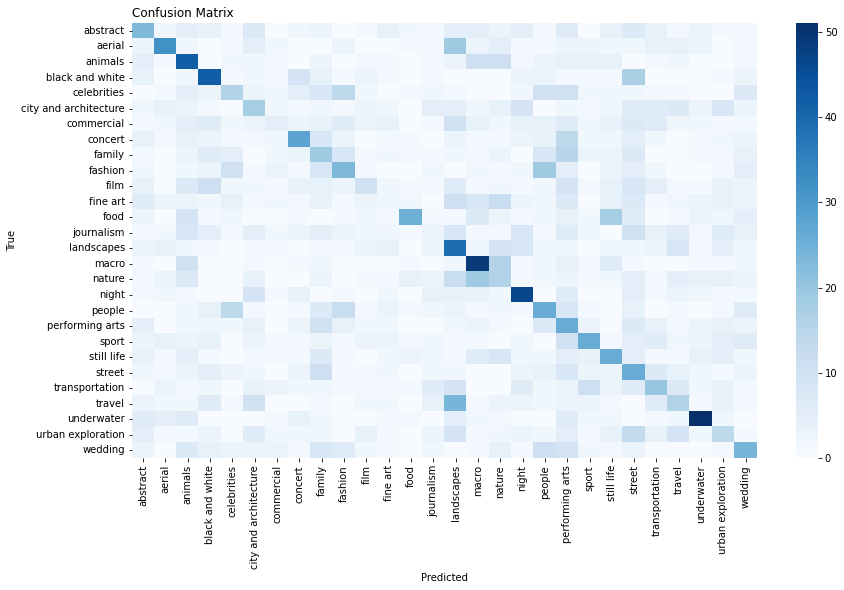

In [29]:
plot_confusion_matrix(y_true, y_pred, train_data)

#### High Kernel Implementation

In [30]:
model_losses['FlatAlexNetHighKernel'] = {}
model_acc['FlatAlexNetHighKernel'] = {}
model_train_test_metrics['FlatAlexNetHighKernel'] = {}

In [20]:
high_kernel_model = FlatAlexNetHighKernel(n_classes=28)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(high_kernel_model.parameters(), lr=.004, momentum=.95)
dtype = torch.float32

In [21]:
print_total_params(high_kernel_model)

Trainable Parameters: 22120476


In [33]:
high_kernel_model, losses = train_network(model=high_kernel_model, criterion=criterion, 
                                                    optimizer=optimizer, dataloader_train=dataloader_train, 
                                                    n_epochs=40)

Epoch: 1 // Running Loss: 550.792 // Accuracy: 0 : 100%|██████████| 170/170 [00:20<00:00,  8.42it/s]
Epoch: 2 // Running Loss: 511.86 // Accuracy: 0.079 : 100%|██████████| 170/170 [00:20<00:00,  8.40it/s] 
Epoch: 3 // Running Loss: 491.809 // Accuracy: 0.11 : 100%|██████████| 170/170 [00:20<00:00,  8.42it/s]
Epoch: 4 // Running Loss: 479.135 // Accuracy: 0.129 : 100%|██████████| 170/170 [00:20<00:00,  8.24it/s]
Epoch: 5 // Running Loss: 463.335 // Accuracy: 0.143 : 100%|██████████| 170/170 [00:20<00:00,  8.48it/s]
Epoch: 6 // Running Loss: 454.065 // Accuracy: 0.157 : 100%|██████████| 170/170 [00:20<00:00,  8.43it/s]
Epoch: 7 // Running Loss: 437.972 // Accuracy: 0.168 : 100%|██████████| 170/170 [00:20<00:00,  8.44it/s]
Epoch: 8 // Running Loss: 426.144 // Accuracy: 0.179 : 100%|██████████| 170/170 [00:20<00:00,  8.50it/s]
Epoch: 9 // Running Loss: 412.93 // Accuracy: 0.189 : 100%|██████████| 170/170 [00:20<00:00,  8.42it/s] 
Epoch: 10 // Running Loss: 394.376 // Accuracy: 0.2 : 100%|█

In [34]:
model_losses['FlatAlexNetHighKernel'] = losses
model_acc['FlatAlexNetHighKernel'] = train_acc

In [36]:
metrics = calculate_metrics(dl_train=dataloader_train, dl_test=dataloader_test, model=high_kernel_model)
print('Train Accuracy / Test Accuracy: ', metrics['accuracy'],
      '\nTrain Precision / Test Precision: ', metrics['precision'])

Calculate Acc. on Test Data: 100%|██████████| 19/19 [00:03<00:00,  5.51it/s]


Train Accuracy / Test Accuracy:  [0.9889798488664987, 0.2033838561861121] 
Train Precision / Test Precision:  [0.9890641467347301, 0.20283181041615422]


In [37]:
model_train_test_metrics['FlatAlexNetHighKernel']['acc'] = metrics['accuracy']
model_train_test_metrics['FlatAlexNetHighKernel']['prec'] = metrics['precision']

In [38]:
y_true, y_pred = network_predict(model=high_kernel_model, dataloader=dataloader_test)

Calculate Acc. on Test Data: 100%|██████████| 19/19 [00:03<00:00,  5.20it/s]


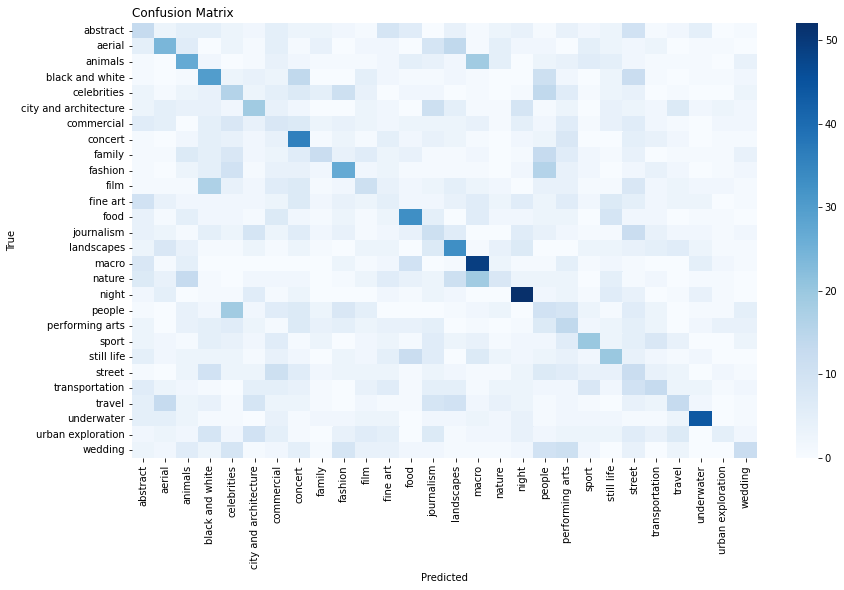

In [39]:
plot_confusion_matrix(y_true, y_pred, train_data)

#### Save results
with open('./src/model_losses_kernel.pkl', 'wb') as pkl_file:
    pickle.dump(model_losses, pkl_file)
with open('./src/model_acc_kernel.pkl', 'wb') as pkl_file:
    pickle.dump(model_acc, pkl_file)
with open('./src/model_train_test_acc_kernel.pkl', 'wb') as pkl_file:
    pickle.dump(model_train_test_metrics, pkl_file)

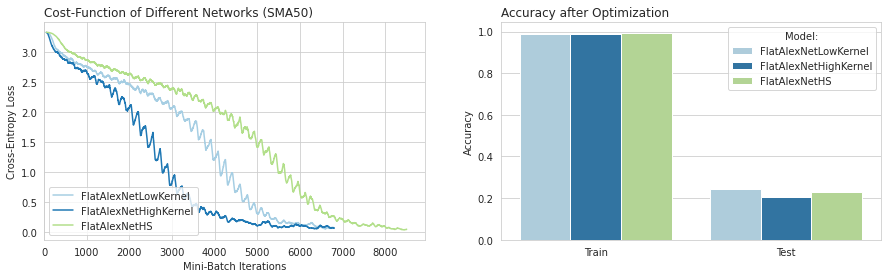

In [23]:
# load results
with open('../src/model_losses_kernel.pkl', 'rb') as pkl_file:
    model_losses = pickle.load(pkl_file)
with open('../src/model_acc_kernel.pkl', 'rb') as pkl_file:
    model_acc = pickle.load(pkl_file)
with open('../src/model_train_test_acc_kernel.pkl', 'rb') as pkl_file:
    model_train_test_metrics = pickle.load(pkl_file)
    
with open('../src/model_losses_stride.pkl', 'rb') as pkl_file:
    model_losses['FlatAlexNetHS'] = pickle.load(pkl_file)['FlatAlexNetHS']
with open('../src/model_acc_stride.pkl', 'rb') as pkl_file:
    model_acc['FlatAlexNetHS'] = pickle.load(pkl_file)['FlatAlexNetHS']
with open('../src/model_train_test_acc_stride.pkl', 'rb') as pkl_file:
    model_train_test_metrics['FlatAlexNetHS'] = pickle.load(pkl_file)['FlatAlexNetHS']

# Transform
model_losses = pd.DataFrame.from_dict(model_losses, orient='index').T
model_acc = pd.DataFrame.from_dict(model_acc)
tmp = pd.DataFrame.from_dict(model_train_test_metrics)

train_test_metrics = pd.DataFrame()
for col in tmp.columns:
    tmp_ = tmp.explode(column=col)[col]
    tmp_.index = ['Train Accuracy', 'Test Accuracy', 'Train Precision', 'Test Precision']
    train_test_metrics = pd.concat([train_test_metrics, tmp_], axis=1)
tmp = train_test_metrics.reset_index()

tmp = tmp[tmp['index'].str.contains('Accuracy')]
tmp = pd.melt(tmp, id_vars=['index'])

#Plot 
plot_evaluation_networks(losses=model_losses, 
                         accuracy=tmp, 
                         key_names=model_losses.columns.to_list(), sma=50)

### Error Estimation of Metric

https://androidkt.com/pytorch-k-fold-cross-validation-using-dataloader-and-sklearn/

In [25]:
from networks import FlatAlexNetHS

In [26]:
hs_model = FlatAlexNetHS(n_classes=28)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(hs_model.parameters(), lr=.002, momentum=.95)
dtype = torch.float32

In [ ]:
metrics = train_network_kfold(model=hs_model, train_data=train_data, test_data=test_data, criterion=criterion, 
                              optimizer=optimizer, n_epochs=30, k_folds=10, batch_sizes=150)

In [28]:
def plot_cv_metrics(metrics: dict):
    df = pd.DataFrame.from_dict(metrics).T
    df['train_precision'] = df['precision'].map(lambda x: x[0])
    df['test_precision'] = df['precision'].map(lambda x: x[1])
    df['train_accuracy'] = df['accuracy'].map(lambda x: x[0])
    df['test_accuracy'] = df['accuracy'].map(lambda x: x[1])
    df = df.drop(['accuracy', 'precision'], axis=1)
    df = df.reset_index()
    df = df.melt(id_vars='index',var_name='name', value_name='score' )
    
    fig = plt.subplots(figsize=(18, 4))
    sns.set_palette('Paired', 4)
    sns.set_style('whitegrid')
    plt.subplot(1,2,1)
    tmp = df[df['name'].str.contains('train')]
    p = sns.boxplot(data=tmp, x='name', y='score')
    p.set_title('Error Estimation of Metrics on Trainset', loc='left')
    p.set_xticklabels(['Precision', 'Accuracy'])
    p.set_xlabel('')
    p.set_ylabel('Score')

    plt.subplot(1,2,2)
    tmp = df[df['name'].str.contains('test')]
    p = sns.boxplot(data=tmp, x='name', y='score' ,width=.5)
    p.set_title('Error Estimation of Metrics on Testset', loc='left')
    p.set_xticklabels(['Precision', 'Accuracy'])
    p.set_xlabel('')
    p.set_ylabel('Score')

    plt.show()

In [31]:
with open('../src/metric_error.pkl', 'rb') as pkl_file:
    metrics = pickle.load(pkl_file)

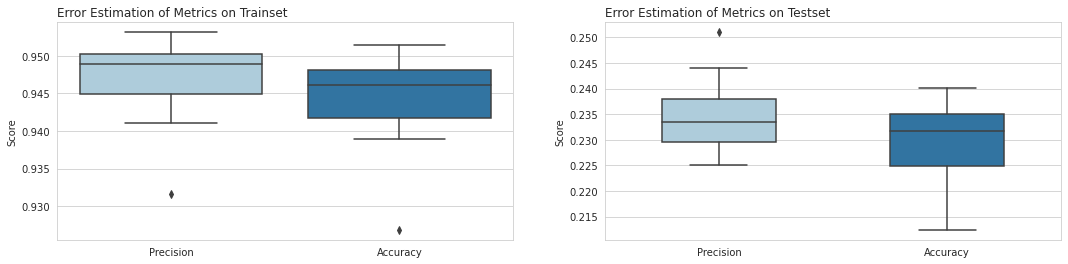

In [32]:
plot_cv_metrics(metrics)